I want to get things ready for Jake so that he can run tests fairly easily.

In [2]:
%load_ext autoreload
%autoreload 2

In [88]:
from BZI.symmetry import make_rptvecs, sym_path
import itertools
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [89]:
def make_ptvecs(lat_type, a, scale=[1,1,1]):
    """Provided the lattice type and constant, return the primitive translation
    vectors.

    Args:
        lat_type (str): the type of lattice of the material.
        a (float or int): the characteristic spacing of atoms in the 
            material.
        scale (list): a list of integers used for created custom primitive
            translation vectors.
    Returns:
        lattice_vectors (numpy.ndarray): returns the primitive translation vectors as
            the columns of a matrix.
    
    Example:
        >>> lattice_type = "fcc"
        >>> a = 1.2
        >>> vectors = primitive_translation_vectors(lattice_type, a)
    """

    if type(a) not in (float, int, np.float64):
        raise ValueError("The lattice constant must be an int or float.")

    if lat_type == "sc":
        a1 = a*np.array([1, 0, 0])
        a2 = a*np.array([0, 1, 0])
        a3 = a*np.array([0, 0, 1])

        lattice_vectors = np.transpose(np.array([a1, a2, a3], dtype=float))
        return lattice_vectors

    elif lat_type == "bcc":    
        a1 = a/2.*np.array([1, 1, -1])
        a2 = a/2.*np.array([-1, 1, 1])
        a3 = a/2.*np.array([1, -1, 1])

        lattice_vectors = np.transpose(np.array([a1, a2, a3], dtype=float))
        return lattice_vectors

    elif lat_type == "fcc":
        a1 = a/2.*np.array([1, 0, 1])
        a2 = a/2.*np.array([1, 1, 0])
        a3 = a/2.*np.array([0, 1, 1])

        lattice_vectors = np.transpose(np.array([a1, a2, a3], dtype=float))
        return lattice_vectors

    elif lat_type == "custom_sc":
        a1 = a*np.array([1, 0, 0])
        a2 = a*np.array([0, 1, 0])
        a3 = a*np.array([0, 0, 1])

        lattice_vectors = scale*np.transpose(np.array([a1, a2, a3], dtype=float))
        return lattice_vectors

    elif lat_type == "custom_bcc":    
        a1 = a/2.*np.array([1, 1, -1])
        a2 = a/2.*np.array([-1, 1, 1])
        a3 = a/2.*np.array([1, -1, 1])

        lattice_vectors = scale*np.transpose(np.array([a1, a2, a3], dtype=float))
        return lattice_vectors

    elif lat_type == "custom_fcc":
        a1 = a/2.*np.array([1, 0, 1])
        a2 = a/2.*np.array([1, 1, 0])
        a3 = a/2.*np.array([0, 1, 1])

        lattice_vectors = scale*np.transpose(np.array([a1, a2, a3], dtype=float))
        return lattice_vectors    
    else:
        msg = "Please provide a sc, bcc, fcc or custom lattice type."
        raise ValueError(msg.format(lat_type))

In [90]:
def make_rptvecs(lat_type, a, scale=[1., 1., 1.]):
    """Provided the lattice type and constant, return the primitive translation
    vectors in reciprocal space.

    Args:
        lat_type (str): the type of lattice of the material.
        a (float or int): the characteristic spacing of atoms in the 
            material.
    Return:
        B (numpy.ndarray): returns the primitive translation vectors in 
        reciprocal space as the columns of a matrix.
    
    Example:
        >>> lat_type = "fcc"
        >>> a = 1.2
        >>> vectors = primitive_translation_vectors(lat_type, a)
    """
    
    ndims = 3
    A = make_ptvecs(lat_type,a)
    V = np.linalg.det(A) # volume of unit cell
    B = np.empty(np.shape(A))
    for i in range(ndims):
        B[:,i] = 2*np.pi*np.cross(A[:,np.mod(i+1, ndims)],
                                  A[:, np.mod(i+2, ndims)])/V
    return scale*B

In [91]:
# Define the symmetry points for a fcc lattice in real space.
# Coordinates are in lattice coordinates.
bcc_sym_pts = {"G": [0,0,0], # G is the gamma point.
               "X": [0,1/2,1/2],
               "L": [1/2,1/2,1/2],
               "W": [1/4,3/4,1/2],
               "U": [1/4,5/8,5/8],
               "K": [3/8,3/4,3/8],
               "G2":[1,1,1]}

# Define the symmetry points for a bcc lattice in real space.
fcc_sym_pts = {"G": [0,0,0],
               "H": [-1/2,1/2,1/2],
               "P": [1/4,1/4,1/4],
               "N": [0,1/2,0]}

# Define the symmetry points for a sc lattice in real space.
sc_sym_pts = {"G": [0,0,0],
              "R": [1/2,1/2,1/2],
              "X": [0,1/2,0],
              "M": [1/2,1/2,0]}

In [92]:
def sym_path(lat_type, npts, sym_pairs):
    """Create an array of coordinates between the provided symmetry points in
    reciprocal space in lattice coordinates.

    Args:
        lat_type (str): the lattice type in real space
        npts (int): the number of coordinates to create between the symmetry
            points.
        sym_pair (numpy.array): an array of point coordinates.

    Return:
        (numpy.array): an array of lattice coordinates along a line connecting
            two symmetry points.
    """
    if lat_type is "fcc":
        dict = bcc_sym_pts
    elif lat_type is "bcc":
        dict = fcc_sym_pts
    elif lat_type is "sc":
        dict = sc_sym_pts
    else:
        raise ValueError("Invalid lattice type")
    paths = []
    for i,sym_pair in enumerate(sym_pairs):
        sym_pti = dict[sym_pair[0]]
        sym_ptf = dict[sym_pair[1]]

        pxi = sym_pti[0]
        pxf = sym_ptf[0]
        pyi = sym_pti[1]
        pyf = sym_ptf[1]
        pzi = sym_pti[2]
        pzf = sym_ptf[2]
        px = np.linspace(pxi,pxf,npts)
        py = np.linspace(pyi,pyf,npts)
        pz = np.linspace(pzi,pzf,npts)
        ipath = [[px[i],py[i],pz[i]] for i in range(len(px))]
        if i is 0:
            paths += ipath
        else:
            del ipath[0]
            paths += ipath
    return paths

In [93]:
# Define the reciprocal lattice points that contribute.
def find_intvecs(a):
    """Find all integer vectors whose squared magnitude is a given value.
    
    Args:
        a (int): the squared magnitude of the desired vectors.
    
    Returns:
        vecs (list): a list of vectors with the provided squared magnitude
    """

    if a == 0:
        return [[0,0,0]]
    # Determine what integers to use for the components of the vectors.
    allowed_ints = []
    for i,j,k in itertools.product(range(-a, a), repeat=3):
        # Exit the loop if the component 
        if (i**2 + j**2 + k**2) == a:
            allowed_ints.append([i,j,k])
    return allowed_ints

In [94]:
def sphere_pts(A,r2,offset):
    """ Calculate all the points within a sphere that are 
    given by an integer linear combination of the columns of 
    A.
    
    Args:
        A (numpy.ndarray): the grid basis with the columns 
            representing basis vectors.
        r2 (float): the squared radius of the sphere.
        offset(list or numpy.ndarray): a vector that points to the center
            of the sphere.
        
    Returns:
        grid (list): an array of grid coordinates in cartesian
            coordinates.
    """
    
    # This is a parameter that should help deal with rounding error.
    eps = 1e-9
    offset = np.asarray(offset)
    
    # Put the offset in lattice coordinates
    oi= np.round(np.dot(np.linalg.inv(A),offset))
    # Find a lattice point close to the offset
    oi = oi.astype(int)
    
    r = np.sqrt(r2)
    V = np.linalg.det(A)
    n = [0,0,0]
    for i in range(3):
        # Add 1 because the offset was rounded to the nearest lattice point.
        n[i] = int(np.ceil(np.linalg.norm(np.cross(A[:,(i+1)%3],A[:,(i+2)%3]))*r/V) + 1)

    grid = []
    for i,j,k in itertools.product(range(-n[0] + oi[0], n[0] + oi[0]),
                                   range(-n[1] + oi[1], n[1] + oi[1]),
                                   range(-n[2] + oi[2], n[2] + oi[2])):
        pt = np.dot(A,[i,j,k])
        if np.dot(pt-offset,pt-offset) <= r2 + eps:
            grid.append(pt)
        else:
            continue                
    return grid

In [95]:
#### Pseudo-potential from The Fermi Surface of Al by Ashcroft #### 

# Define the pseudopotential form factors taken from Ashcroft for Al.
Al_pff = [0.0179, 0.0562]

# Al_rlat_pts = find_intvecs(0) + find_intvecs(3) + find_intvecs(4)
Al_lat_const = 7.765
Al_lat_type = "fcc"
Al_lat_vecs = make_rptvecs(Al_lat_type, Al_lat_const)
Al_rlat_pts = sphere_pts(Al_lat_vecs, 21*(2*np.pi/Al_lat_const)**2, [0,0,0])

# The number of contributing reciprocal lattice points determines the size
# of the Hamiltonian.
nAl = len(Al_rlat_pts)
Ry_to_eV = 13.605698066
offset = 10
def AlPP(kpoint,nbands):
    """Evaluate an Al pseudopotential at a given k-point. The pseudopotential
    form factors were taken from 
    `Harrison <http://journals.aps.org/pr/abstract/10.1103/PhysRev.116.555`_.

    Args:
        kpoint (numpy.array): a sampling point in k-space.

    Return:
        (numpy.array): the sorted eigenvalues of the Hamiltonian at the provided
        k-point.
    """

    # Initialize the Al pseudopotential Hamiltonian.
    Al_H = np.zeros([nAl, nAl])
    # Construct the Al Hamiltonian.
    for (i, k1) in enumerate(Al_rlat_pts):
        k1 = np.asarray(k1)
        for (j, k2) in enumerate(Al_rlat_pts):
            k2 = np.asarray(k2)
            n2 = norm(k2 - k1)**2
            if i == j:
                Al_H[i,j] = np.dot(kpoint + k1, kpoint + k1)
            elif np.isclose(n2, 3*(2*np.pi/Al_lat_const)**2) == True:
                Al_H[i,j] = Al_pff[0]
            elif np.isclose(n2, 4*(2*np.pi/Al_lat_const)**2) == True:
                Al_H[i,j] = Al_pff[1]
            else:
                continue
                
    return np.sort(np.linalg.eigvals(Al_H))[:nbands]*Ry_to_eV - offset

In [96]:
def plot_bandstructure(material, npts):
    """Plot the band structure.
    
    Args:
        material (string): a string indicating which pseudopotenial
            to implement.
        npts (float): the number of points for each symmetry path.    
    """

    if material == "Si":
        PP = SiPP
        lat_const = 10.26121
    elif material == "GaAs":
        PP = GaAsPP
        lat_const = 10.65806
    elif material == "New":
        PP = newSiPP
        lat_const = 10.26121
    elif material == "Al":
        PP = AlPP
        lat_const = 7.65
    else:
        raise InputError("Invalid material provided")

    # sympt_pairs = [("L","G"),("G","X"),("X","U"),("U","G2")]
    sympt_pairs = [("G","X"),("X","W"),("W","K"),("K","G"),
                   ("G","L"),("L","U"),("U","W"),("W","L"),
                   ("L","K"),("U","X")]
    lat_type = "fcc"
    rlat_vecs = make_rptvecs(lat_type, lat_const)
    
    # The k-points between symmetry points in reciprocal lattice coordinates.
    lat_kpoints = sym_path(lat_type,npts,sympt_pairs)
    
    # The k-points between symmetry points in cartesian coordinates.
    car_kpoints = [np.dot(rlat_vecs,k) for k in lat_kpoints]
    
    # Place all eigenvalues in a nested list.
    energies = []
    nbands = 8
    for kpt in car_kpoints:
        energies.append(PP(kpt, nbands))
    # Grad the symmetry points.
    G = np.array(car_kpoints[0])
    X = np.array(car_kpoints[npts-1])
    W = np.array(car_kpoints[2*(npts-1)])
    K = np.array(car_kpoints[3*(npts-1)])
    # G2 = np.array(car_kpoints[4*(npts-1)])
    L = np.array(car_kpoints[5*(npts-1)])    
    U = np.array(car_kpoints[6*(npts-1)])
    
    # Find the distances between symmetry points.
    l1 = np.linalg.norm(X - G)
    l2 = np.linalg.norm(W - X)
    l3 = np.linalg.norm(K - W)
    l4 = np.linalg.norm(G - K)
    l5 = np.linalg.norm(L - G)
    l6 = np.linalg.norm(U - L)
    l7 = np.linalg.norm(W - U)
    l8 = np.linalg.norm(L - W)
    l9 = np.linalg.norm(K - L)    
    l10 = np.linalg.norm(X - U)
    
    
    ltot = l1 + l2 + l3 + l4 + l5 + l6 + l7 + l8 + l9 + l10

    # Create x-coordinates used for plotting that go from
    # 0 to the sum of symmetry path lengths. 
    # Unfortunately shorter symmetry paths with have higher resolution.
    line1 = list(np.delete(np.linspace(0,l1,npts),-1))
    line2 = list(np.delete(np.linspace(l1,l1+l2,npts),-1))
    line3 = list(np.delete(np.linspace(l1+l2,l1+l2+l3,npts),-1))
    line4 = list(np.delete(np.linspace(l1+l2+l3,l1+l2+l3+l4,npts),-1))
    line5 = list(np.delete(np.linspace(l1+l2+l3+l4,l1+l2+l3+l4+l5,npts),-1))
    line6 = list(np.delete(np.linspace(l1+l2+l3+l4+l5
                                       ,l1+l2+l3+l4+l5+l6,npts),-1))
    line7 = list(np.delete(np.linspace(l1+l2+l3+l4+l5+l6
                                       ,l1+l2+l3+l4+l5+l6+l7,npts),-1))
    line8 = list(np.delete(np.linspace(l1+l2+l3+l4+l5+l6+l7
                                       ,l1+l2+l3+l4+l5+l6+l7+l8,npts),-1))
    line9 = list(np.delete(np.linspace(l1+l2+l3+l4+l5+l6+l7+l8,
                                       l1+l2+l3+l4+l5+l6+l7+l8+l9,npts),-1))
    line10 = list(np.linspace(l1+l2+l3+l4+l5+l6+l7+l8+l9,ltot,npts))
    
    lines = line1 + line2 + line3 + line4 + line5 + line6 + line7 + line8 + (
            line9 + line10)
    

    # Plot the energy dispersion curves one at a time.
    for nb in range(nbands):
        ienergy = []
        for nk in range(len(car_kpoints)):
            ienergy.append(energies[nk][nb])
        plt.plot(lines, ienergy, color="black")
#         if nb == 0:
#             plt.plot(lines, ienergy, color="black", label="Band structure")
#         else:
#             plt.plot(lines, ienergy, color="black")

    # Plot a vertical line at the symmetry points with proper labels
    plt.axvline(x = l1, c="gray")
    plt.axvline(x = l1 + l2, c="gray")
    plt.axvline(x = l1 + l2 + l3, c="gray")
    plt.axvline(x = l1 + l2 + l3 + l4, c="gray")
    plt.axvline(x = l1 + l2 + l3 + l4 + l5, c="gray")
    plt.axvline(x = l1 + l2 + l3 + l4 + l5 + l6, c="gray")
    plt.axvline(x = l1 + l2 + l3 + l4 + l5 + l6 + l7, c="gray")
    plt.axvline(x = l1 + l2 + l3 + l4 + l5 + l6 + l7 + l8, c="gray")
    plt.axvline(x = l1 + l2 + l3 + l4 + l5 + l6 + l7 + l8 + l9, c="gray")
    plt.axvline(x = l1 + l2 + l3 + l4 + l5 + l6 + l7 + l8 + l9 + l10, c="gray")
    
    tick_labels = ["$\Gamma$", "X", "W", "K", "$\Gamma$", "L", 
                   "U", "W", "L", "K|U", "X"]
    tick_locs = [0, 
                 l1,
                 l1 + l2,
                 l1 + l2 + l3, 
                 l1 + l2 + l3 + l4,
                 l1 + l2 + l3 + l4 + l5,
                 l1 + l2 + l3 + l4 + l5 + l6,
                 l1 + l2 + l3 + l4 + l5 + l6 + l7,
                 l1 + l2 + l3 + l4 + l5 + l6 + l7 + l8,                 
                 l1 + l2 + l3 + l4 + l5 + l6 + l7 + l8 + l9,
                 ltot]

    plt.xticks(tick_locs,tick_labels)
    # plt.yticks(range(-5,8,1),range(-5,8,1))
    # plt.ylim([-10, 10])
    plt.xlim([0,ltot])
    plt.xlabel("Symmetry points")
    plt.ylabel("Energy (eV)")
    plt.title("%s Band Structure"%material)
    plt.grid(linestyle="dotted")
    plt.show()
    # lgd = plt.legend(loc='center left', bbox_to_anchor=(.115, .09),fancybox=True)
    # lgd.get_frame().set_alpha(0.2)
    # plt.savefig("%s_band_struct.pdf" %material)#, bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=1000,transparent=True)
    # plt.show()
    # plt.close()

/usr/local/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


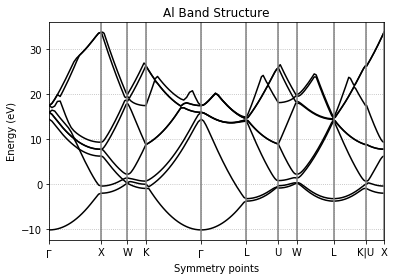

In [97]:
plot_bandstructure("Al", 20)

In [98]:
"""Various methods of sampling the Brillouin zone.
"""
 
import numpy as np
from copy import deepcopy
from itertools import product
from math import ceil
from BZI.symmetry import make_ptvecs

# Find transformation to create HNF from integer matrix.
def get_minmax_indices(a):
    """Find the maximum and minimum elements of a list that aren't zero.

    Args:
        a (numpy.ndarray): a three element numpy array.

    Returns:
        minmax (list): the minimum and maximum values of array a with the
            minimum first and maximum second.
    """
    a = np.abs(a)
    maxi = 2 - np.argmax(a[::-1])
    min = 0
    i = 0
    while min == 0:
        min = a[i]
        i += 1
    mini = i-1
    for i,ai in enumerate(a):
        if ai > 0 and ai < min:
            min = ai
            mini = i
#     min = np.size(a) - 1 - a[::-1][a > 0].argmin()
    return np.asarray([mini, maxi])

def swap_column(M, B, k):
    """Swap the column k with whichever column has the highest value (out of
    the columns to the right of k in row k). The swap is performed for both
    matrices M and B. 

    Args:
        M (numpy.ndarray): the matrix being transformed
        B (numpy.ndarray): a matrix to keep track of the transformation steps 
            on M. 
        k (int): the column to swap, as described in summary.
    """
    
    Ms = deepcopy(M)
    Bs = deepcopy(B)
    
    # Find the index of the non-zero element in row k.
    maxidx = np.argmax(np.abs(Ms[k,k:])) + k
    tmpCol = deepcopy(Bs[:,k]);
    Bs[:,k] = Bs[:,maxidx]
    Bs[:,maxidx] = tmpCol

    tmpCol = deepcopy(Ms[:,k])
    Ms[:,k] = Ms[:, maxidx]
    Ms[:,maxidx] = tmpCol

    return Ms, Bs

def swap_row(M, B, k):
    """Swap the row k with whichever row has the highest value (out of
    the rows below k in column k). The swap is performed for both matrices M and B.

    Args:
        M (numpy.ndarray): the matrix being transformed
        B (numpy.ndarray): a matrix to keep track of the transformation steps 
            on M. 
        k (int): the column to swap, as described in summary.
    """
    
    Ms = deepcopy(M)
    Bs = deepcopy(B)
    
    # Find the index of the non-zero element in row k.
    maxidx = np.argmax(np.abs(Ms[k:,k])) + k

    tmpCol = deepcopy(Bs[k,:]);
    Bs[k,:] = Bs[maxidx,:]
    Bs[maxidx,:] = tmpCol
    
    tmpRow = deepcopy(Ms[k,:])
    Ms[k,:] = Ms[maxidx,:]
    Ms[maxidx,:] = tmpRow

    return Ms, Bs

def LowerHermiteNormalForm(S):
    """Find the Hermite normal form (HNF) of a given integer matrix and the
    matrix that mediates the transformation.

    Args:
        S (numpy.ndarray): The 3x3 integer matrix describing the relationship 
            between two commensurate lattices.
    Returns:
        H (numpy.ndarray): The resulting HNF matrix.
        B (numpy.ndarray): The transformation matrix such that H = SB.
    """
    if np.linalg.det(S) == 0:
        raise ValueError("Singular matrix passed to HNF routine")
    B = np.identity(np.shape(S)[0]).astype(int)
    H = deepcopy(S)
    
#    Keep doing column operations until all elements in the first row are zero
#    except for the one on the diagonal.
    while np.count_nonzero(H[0,:]) > 1:
        # Divide the column with the smallest value into the largest.
        minidx, maxidx = get_minmax_indices(H[0,:])
        minm = H[0,minidx]
        # Subtract a multiple of the column containing the smallest element from
        # the row containing the largest element.
        multiple = int(H[0, maxidx]/minm)
        H[:, maxidx] = H[:, maxidx] - multiple*H[:, minidx]
        B[:, maxidx] = B[:, maxidx] - multiple*B[:, minidx]
        if np.allclose(np.dot(S, B), H) == False:
            raise ValueError("COLS: Transformation matrices didn't work.")
    if H[0,0] == 0:
        H, B = swap_column(H, B, 0) # Swap columns if (0,0) is zero.
    if H[0,0] < 0:
        H[:,0] = -H[:,0]
        B[:,0] = -B[:,0]

    if np.count_nonzero(H[0,:]) > 1:
        raise ValueError("Didn't zero out the rest of the row.")
    if np.allclose(np.dot(S, B), H) == False:
        raise ValueError("COLSWAP: Transformation matrices didn't work.")
    # Now work on element H[1,2].
    while H[1,2] != 0:
        if H[1,1] == 0:
            tempcol = deepcopy(H[:,1])
            H[:,1] = H[:,2]
            H[:,2] = tempcol

            tempcol = deepcopy(B[:,1])
            B[:,1] = B[:,2]
            B[:,2] = tempcol
            if H[1,2] == 0:
                break            
        if np.abs(H[1,2]) < np.abs(H[1,1]):
            maxidx = 1
            minidx = 2
        else:
            maxidx = 2
            minidx = 1

        multiple = int(H[1, maxidx]/H[1,minidx])
        H[:,maxidx] = H[:, maxidx] - multiple*H[:,minidx]
        B[:,maxidx] = B[:, maxidx] - multiple*B[:,minidx]
        
        if np.allclose(np.dot(S, B), H) == False:
            raise ValueError("COLS: Transformation matrices didn't work.")

    if H[1,1] == 0:
        tempcol = deepcopy(H[:,1])
        H[:,1] = H[:,2]
        H[:,2] = tempcol
    if H[1,1] < 0: # change signs
        H[:,1] = -H[:,1]
        B[:,1] = -B[:,1]
    if H[1,2] != 0:
        raise ValueError("Didn't zero out last element.")
    if np.allclose(np.dot(S,B), H) == False:
        raise ValueError("COLSWAP: Transformation matrices didn't work.")
    if H[2,2] < 0: # change signs
        H[:,2] = -H[:,2]
        B[:,2] = -B[:,2]
    check1 = (np.array([0,0,1]), np.array([1,2,2]))
    if np.count_nonzero(H[check1]) != 0:
        raise ValueError("Not lower triangular")
    if np.allclose(np.dot(S, B), H) == False:
        raise ValueError("End Part1: Transformation matrices didn't work.")
    
    # Now that the matrix is in lower triangular form, make sure the lower
    # off-diagonal elements are non-negative but less than the diagonal
    # elements.
    while H[1,1] <= H[1,0] or H[1,0] < 0:
        if H[1,1] <= H[1,0]:
            multiple = 1
        else:
            multiple = -1
        H[:,0] = H[:,0] - multiple*H[:,1]
        B[:,0] = B[:,0] - multiple*B[:,1]
    for j in [0,1]:
        while H[2,2] <= H[2,j] or H[2,j] < 0:
            if H[2,2] <= H[2,j]:
                multiple = 1
            else:
                multiple = -1
            H[:,j] = H[:,j] - multiple*H[:,2]
            B[:,j] = B[:,j] - multiple*B[:,2]

    if np.allclose(np.dot(S, B), H) == False:
        raise ValueError("End Part1: Transformation matrices didn't work.")
    if np.count_nonzero(H[check1]) != 0:
        raise ValueError("Not lower triangular")
    check2 = (np.asarray([0, 1, 1, 2, 2, 2]), np.asarray([0, 0, 1, 0, 1, 2]))
    if any(H[check2] < 0) == True:
        raise ValueError("Negative elements in lower triangle.")

    if H[1,0] > H[1,1] or H[2,0] > H[2,2] or H[2,1] > H[2,2]:
        raise ValueError("Lower triangular elements bigger than diagonal.")
    return H, B

def HermiteNormalForm(S):
    """Find the Hermite normal form (HNF) of a given integer matrix and the
    matrix that mediates the transformation.

    Args:
        S (numpy.ndarray): The 3x3 integer matrix describing the relationship 
            between two commensurate lattices.
    Returns:
        H (numpy.ndarray): The resulting HNF matrix.
        B (numpy.ndarray): The transformation matrix such that H = SB.
    """
    if np.linalg.det(S) == 0:
        raise ValueError("Singular matrix passed to HNF routine")
    B = np.identity(np.shape(S)[0]).astype(int)
    H = deepcopy(S)

    #    Keep doing row operations until all elements in the first column are zero
    #    except for the one on the diagonal.
    while np.count_nonzero(H[:,0]) > 1:
        # Divide the row with the smallest value into the largest.
        minidx, maxidx = get_minmax_indices(H[:,0])
        minm = H[minidx,0]
        # Subtract a multiple of the row containing the smallest element from
        # the row containing the largest element.
        multiple = int(H[maxidx,0]/minm)
        H[maxidx,:] = H[maxidx,:] - multiple*H[minidx,:]
        B[maxidx,:] = B[maxidx,:] - multiple*B[minidx,:]
        if np.allclose(np.dot(B, S), H) == False:
            raise ValueError("ROWS: Transformation matrices didn't work.")
    if H[0,0] == 0:
        H, B = swap_row(H, B, 0) # Swap rows if (0,0) is zero.
    if H[0,0] < 0:
        H[0,:] = -H[0,:]
        B[0,:] = -B[0,:]
    if np.count_nonzero(H[:,0]) > 1:
        raise ValueError("Didn't zero out the rest of the row.")
    if np.allclose(np.dot(B,S), H) == False:
        raise ValueError("ROWSWAP: Transformation matrices didn't work.")
    # Now work on element H[2,1].
    while H[2,1] != 0:
        if H[1,1] == 0:
            temprow = deepcopy(H[1,:])
            H[1,:] = H[2,:]
            H[2,:] = temprow

            temprow = deepcopy(B[1,:])
            B[1,:] = B[2,:]
            B[2,:] = temprow
            break         
        if np.abs(H[2,1]) < np.abs(H[1,1]):
            maxidx = 1
            minidx = 2
        else:
            maxidx = 2
            minidx = 1
        
        multiple = int(H[maxidx,1]/H[minidx,1])
        H[maxidx,:] = H[maxidx,:] - multiple*H[minidx,:]
        B[maxidx,:] = B[maxidx,:] - multiple*B[minidx,:]

        if np.allclose(np.dot(B,S), H) == False:
            raise ValueError("COLS: Transformation matrices didn't work.")

    if H[1,1] == 0:
        temprow = deepcopy(H[1,:])
        H[1,:] = H[0,:]
        H[0,:] = temprow
    if H[1,1] < 0: # change signs
        H[1,:] = -H[1,:]
        B[1,:] = -B[1,:]
    if H[1,0] != 0:
        raise ValueError("Didn't zero out last element.")
    if np.allclose(np.dot(B,S), H) == False:
        raise ValueError("COLSWAP: Transformation matrices didn't work.")
    if H[2,2] < 0: # change signs
        H[2,:] = -H[2,:]
        B[2,:] = -B[2,:]
    check1 = (np.array([2,2,1]), np.array([1,0,0]))

    if np.count_nonzero(H[check1]) != 0:
        raise ValueError("Not lower triangular")
    if np.allclose(np.dot(B,S), H) == False:
        raise ValueError("End Part1: Transformation matrices didn't work.")

    # Now that the matrix is in lower triangular form, make sure the lower
    # off-diagonal elements are non-negative but less than the diagonal
    # elements.    
    while H[1,1] <= H[0,1] or H[0,1] < 0:
        if H[1,1] <= H[0,1]:
            multiple = 1
        else:
            multiple = -1
        H[0,:] = H[0,:] - multiple*H[1,:]
        B[0,:] = B[0,:] - multiple*B[1,:]
    for j in [0,1]:
        while H[2,2] <= H[j,2] or H[j,2] < 0:
            if H[2,2] <= H[j,2]:
                multiple = 1
            else:
                multiple = -1
            H[j,:] = H[j,:] - multiple*H[2,:]
            B[j,:] = B[j,:] - multiple*B[2,:]

    if np.allclose(np.dot(B, S), H) == False:
        raise ValueError("End Part1: Transformation matrices didn't work.")
    if np.count_nonzero(H[check1]) != 0:
        raise ValueError("Not lower triangular")
    check2 = (np.asarray([0, 0, 0, 1, 1, 2]), np.asarray([0, 1, 2, 1, 2, 2]))
    if any(H[check2] < 0) == True:
        raise ValueError("Negative elements in lower triangle.")
    if H[0,1] > H[1,1] or H[0,2] > H[2,2] or H[1,2] > H[2,2]:
        raise ValueError("Lower triangular elements bigger than diagonal.")
    return H, B

def make_mesh(cell_vecs, grid_vecs, offset):
    """Sample within a parallelepiped using any regular grid.

    Args:
        cell_vecs (numpy.ndarray): the vectors defining the volume in which 
            to sample. The vectors are the columns of the matrix.
        grid_vecs (numpy.ndarray): the vectors that generate the grid as 
            columns of the matrix..
        offset: the origin of the coordinate system.

    Returns:
        grid (numpy.ndarray): an array of sampling-point coordinates.

    Examples:
        >>> cell_type = "fcc"
        >>> cell_const = 1.
        >>> cell_vecs = make_ptvecs(cell_type, cell_const)

        >>> grid_type = "bcc"
        >>> grid_const = cell_const/140
        >>> grid_vecs = make_ptvecs(grid_type, grid_const)
        >>> offset = [0.5, 0.5, 0.5]
        >>> grid = make_grid(cell_vecs, grid_vecs, offset)
    """
    
    # Integer matrix
    N = np.dot(np.linalg.inv(grid_vecs), cell_vecs)
    # Check that N is an integer matrix.
    for i in range(len(N[:,0])):
        for j in range(len(N[0,:])):
            if np.isclose(N[i,j]%1, 0) or np.isclose(N[i,j]%1, 1):
                N[i,j] = int(np.round(N[i,j]))
            else:
                raise ValueError("The cell and grid vectors are incommensurate.")
            
    # H is an HNF and U is the transform.
    L, U = HermiteNormalForm(N)
    a = L[0,0]
    b = L[0,1]
    c = L[0,2]
    d = L[1,1]
    e = L[1,2]
    f = L[2,2]
    cell_const = np.linalg.norm(cell_vecs[:,0])
    
    grid = []
    z3pl = 0
    z3pu = int(f)
    for z3p in range(z3pl + 1, z3pu + 1):
        z2pl = int(e*z3p/f) # lower and upper limits
        z2pu = int(z2pl + d)
        for z2p in range(z2pl + 1, z2pu + 1):
            z1pl = int((c - b*e/d)*z3p/f + b/d*z2p)
            z1pu = int(z1pl + a)
            for z1p in range(z1pl + 1, z1pu + 1):
                z = np.dot(np.linalg.inv(U), [z1p,z2p,z3p])
                pt = np.dot(grid_vecs, z)
                gpt = np.dot(np.linalg.inv(cell_vecs), pt)%1
                grid.append(np.dot(cell_vecs, gpt) - offset)
    return grid

In [100]:
def rectangular_method(PP, mesh, cell_vecs, cutoff):
    """Integrate a pseudo-potential within a cell below a cutoff energy.
    
    Args:
        PP (function): the pseudopotential
        mesh (list): a list of mesh points
        cell_vecs (numpy.ndarray): a 3x3 numpy array with cell vectors as columns
        cutoff (float): the cutoff energy or Fermi level
    """
    
    integral = 0
    for kpt in mesh:
        integral += sum(filter(lambda x: x <= cutoff, PP(kpt)))
    return np.linalg.det(cell_vecs)/len(mesh)*integral

In [103]:
import time
t1 = time.time()
AlPP([0,0,0],8)
print(time.time() - t1)

0.8818020820617676
